# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

## Dataset

In [2]:
# Dataset path
file_path = 'data/Real_estate.csv'

# Load the dataset as df
df = pd.read_csv(file_path)

In [3]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
# Evaluate the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [5]:
# Verify whether there are any missing values
df.isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [6]:
# Verify whether there are any duplicated values
df.duplicated().sum()

np.int64(0)

In [7]:
# Drop outlier
df_dropped = df.sort_values(by='Y house price of unit area', ascending=False).iloc[1:]

In [8]:
# Rename the columns for better appplication
df_names = df_dropped.rename(columns={
    'Y house price of unit area': 'unit_price',
    'X1 transaction date': 'transaction_date',
    'X2 house age': 'house_age',
    'X3 distance to the nearest MRT station': 'distance_to_station',
    'X4 number of convenience stores': 'convenience_stores_number',
    'X5 latitude': 'latitude',
    'X6 longitude': 'longitude'
})
df_names

,No,transaction_date,house_age,distance_to_station,convenience_stores_number,latitude,longitude,unit_price
220,221,2013.333,37.2,186.5101,9,24.97703,121.54265,78.3
312,313,2013.583,35.4,318.5292,9,24.97071,121.54069,78.0
166,167,2013.417,0.0,292.9978,6,24.97744,121.54458,73.6
105,106,2012.833,0.0,292.9978,6,24.97744,121.54458,71.0
16,17,2013.250,0.0,292.9978,6,24.97744,121.54458,70.1
...,...,...,...,...,...,...,...,...
330,331,2013.083,32.0,1156.7770,0,24.94935,121.53046,12.8
116,117,2013.000,30.9,6396.2830,1,24.94375,121.47883,12.2
162,163,2012.750,16.0,4066.5870,0,24.94297,121.50342,11.6
347,348,2013.583,17.4,6488.0210,1,24.95719,121.47353,11.2


# Cross-validation

In [9]:
# Define the X and Y
X = df_names.drop('unit_price', axis =1).drop('No', axis =1)
y = df_names['unit_price']


# Split it in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Data preparation 

### 1. Scale features

In [10]:
# Convert the dates into datetime type
def decimal_year_to_year_month(decimal_year: pd.DataFrame) -> pd.DataFrame:
    """Convert decimal year to year-month datetime"""

    year = int(decimal_year)
    month = int((decimal_year - year) * 12) + 1  # +1 since months start at 1
    return datetime(year, month, 1)

X_train['transaction_datetime'] = X_train['transaction_date'].apply(decimal_year_to_year_month)
X_test['transaction_datetime'] = X_test['transaction_date'].apply(decimal_year_to_year_month)

# Extract month and year
X_train['year_month'] = X_train['transaction_datetime'].dt.to_period('M').astype(str)
X_test['year_month'] = X_test['transaction_datetime'].dt.to_period('M').astype(str)

# Drop datetime column
drop_X_train = X_train.drop('transaction_datetime', axis=1)
drop_X_test = X_test.drop('transaction_datetime', axis=1)

In [11]:
drop_X_train

,transaction_date,house_age,distance_to_station,convenience_stores_number,latitude,longitude,year_month
69,2012.833,12.5,561.98450,5,24.98746,121.54391,2012-10
197,2013.250,34.4,126.72860,8,24.96881,121.54089,2013-04
36,2012.917,14.7,1935.00900,2,24.96386,121.51458,2012-12
177,2013.083,33.0,181.07660,9,24.97697,121.54262,2013-01
275,2012.667,1.5,23.38284,7,24.96772,121.54102,2012-09
...,...,...,...,...,...,...,...
306,2013.500,14.4,169.98030,1,24.97369,121.52979,2013-07
299,2013.167,33.2,121.72620,10,24.98178,121.54059,2013-03
199,2013.417,18.2,451.64190,8,24.96945,121.54490,2013-06
169,2013.417,8.4,1962.62800,1,24.95468,121.55481,2013-06


In [12]:
#Standard scaler
scaler = StandardScaler()

In [13]:
# One-hot encoder for months
encoder = OneHotEncoder()

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 69 to 343
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_date           276 non-null    float64       
 1   house_age                  276 non-null    float64       
 2   distance_to_station        276 non-null    float64       
 3   convenience_stores_number  276 non-null    int64         
 4   latitude                   276 non-null    float64       
 5   longitude                  276 non-null    float64       
 6   transaction_datetime       276 non-null    datetime64[ns]
 7   year_month                 276 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 19.4+ KB


### 2. Preprocess the dataset

In [15]:
preprocessor = ColumnTransformer(
    [
        ("distance_scaler", scaler, ["distance_to_station"]),
        ("house_age", scaler, ["house_age"]),
        ("stores_number", scaler, ["convenience_stores_number"]),
        ("year_month", encoder, ["year_month"]),
        ("latitude", scaler, ["latitude"]),
        ("longitude", scaler, ["longitude"]),
    ],
)
preprocessor

,transformers,"[('distance_scaler', ...), ('house_age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### 3. Apply the changes

In [16]:
scaled_X_train = pd.DataFrame(preprocessor.fit_transform(drop_X_train))
scaled_X_test = pd.DataFrame(preprocessor.fit_transform(drop_X_test))

## Model

In [17]:
base_model = LinearRegression().fit(scaled_X_train, y_train)

In [18]:
cv_results = cross_val_score(base_model, scaled_X_train, y_train, cv=5, scoring ='r2' ).mean()
cv_results

np.float64(0.5796009218400968)

In [40]:
cv_results = cross_val_score(base_model, scaled_X_train, y_train, cv=5, scoring ='neg_mean_squared_error' ).mean()
cv_results

np.float64(-66.85381323076726)

In [19]:
base_model.score(scaled_X_test, y_test)

0.649286552011052

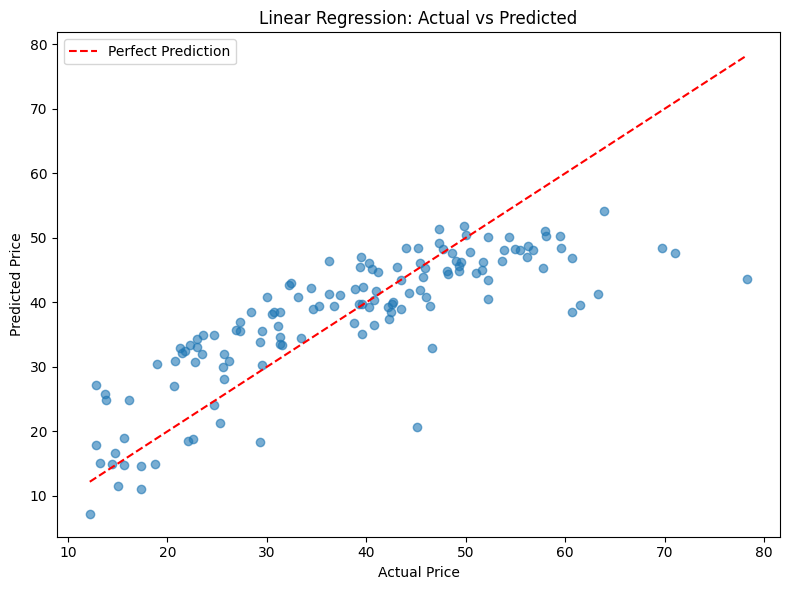

In [20]:
# Predict
y_pred = base_model.predict(scaled_X_test)

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

### ~ Bonus ~

In [ ]:
inverse_transformer = FunctionTransformer(func=lambda x: 1 / x)

In [28]:
preprocessor2 = ColumnTransformer(
    [
        ("inv_distance", Pipeline([
            ("inverse", inverse_transformer),
            ("scaler", StandardScaler())
        ]), ["distance_to_station"]),
        ("house_age", Pipeline([('scaler', scaler)]), ["house_age"]),
        ("stores_number", Pipeline([('scaler', scaler)]), ["convenience_stores_number"]),
        ("year_month", Pipeline([('encoder', encoder)]), ["year_month"]),
        ("latitude", Pipeline([('scaler', scaler)]), ["latitude"]),
        ("longitude", Pipeline([('scaler', scaler)]), ["longitude"]),
    ],
)
preprocessor2

,transformers,"[('inv_distance', ...), ('house_age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,func,<function <la...x71167c78e440>
,inverse_func,None
,validate,False
